In [2]:
import cv2
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.src.layers import Conv2DTranspose
from keras.src.losses import losses
import os

In [3]:
def evaluate_segmentation(y_true, y_pred, threshold=0.5):   
    # Calculate intersection and union
    intersection = np.sum(y_true * y_pred) // 2
    sum_y_true = np.sum(y_true)
    sum_y_pred = np.sum(y_pred)
    
    # Dice coefficient with small epsilon to avoid division by zero
    dice = (2 * intersection) / (sum_y_true + sum_y_pred + 1e-7)
    return dice

In [4]:
class Ellipse:
    def __init__(self, image_size=256, short_axis_min=100, long_axis_min=250, noise_diameter_max=30):
        self.image_size = image_size
        self.short_axis_min = short_axis_min
        self.long_axis_min = long_axis_min
        self.noise_diameter_max = noise_diameter_max
        
        self.ellipse, self.noisy_ellipse = self.generate_ellipse_with_noise()
    
    def generate_ellipse_with_noise(self):
        image = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        
        center = (self.image_size // 2, self.image_size // 2)
        short_axis = random.randint(self.short_axis_min // 2, self.image_size // 2)
        long_axis = min(random.randint(self.long_axis_min, self.image_size), short_axis * 3)
        
        ellipse_image = cv2.ellipse(image.copy(), center, (long_axis, short_axis), 0, 0, 360, 1, -1)
        
        noisy_image = self.add_noise(ellipse_image)
        
        return ellipse_image, noisy_image
    
    def add_noise(self, image):
        noisy_image = image.copy()
        
        num_noises = random.randint(5, 15)
        
        for _ in range(num_noises):
            x = random.randint(0, self.image_size - 1)
            y = random.randint(0, self.image_size - 1)
            diameter = random.randint(5, self.noise_diameter_max)
            
            cv2.circle(noisy_image, (x, y), diameter // 2, 0, -1)
            
        return noisy_image

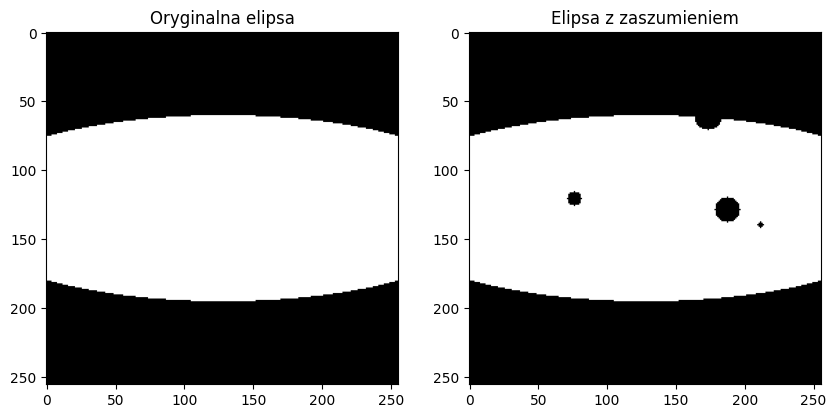

In [5]:
ellipse = Ellipse()

# Wyświetlanie obrazów oryginalnego i zaszumionego
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Oryginalna elipsa")
plt.imshow(ellipse.ellipse, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Elipsa z zaszumieniem")
plt.imshow(ellipse.noisy_ellipse, cmap='gray')
plt.show()

In [6]:
class EllipseDataset:
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.ellipses = [Ellipse().ellipse for _ in range(num_samples)]
        self.noisy_ellipses = [Ellipse().noisy_ellipse for _ in range(num_samples)]
            
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.ellipses[idx]
    
    def save_to_bmp(self, path):
        # Create the directories if they don't exist
        ellipse_dir = os.path.join(path, "ellipses")
        noisy_ellipse_dir = os.path.join(path, "noisy_ellipses")
        
        os.makedirs(ellipse_dir, exist_ok=True)
        os.makedirs(noisy_ellipse_dir, exist_ok=True)
        
        # Save ellipses
        for i, ellipse in enumerate(self.ellipses):
            cv2.imwrite(os.path.join(ellipse_dir, f"ellipse_{i}.bmp"), ellipse)
            
        # Save noisy ellipses
        for i, noisy_ellipse in enumerate(self.noisy_ellipses):
            cv2.imwrite(os.path.join(noisy_ellipse_dir, f"noisy_ellipse_{i}.bmp"), noisy_ellipse)

In [7]:
dataset = EllipseDataset(1000)

@keras.saving.register_keras_serializable()
class Autoencoder(Model):
    def __init__(self, input_shape=(256, 256, 1)):
        self.input_shape_ = input_shape
        super(Autoencoder, self).__init__()
        # Encoder
        self.input_img = Input(shape=input_shape)
        self.encoder = keras.Sequential([
            Input(shape=input_shape),
            Conv2D(128, (5, 5), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(32, (5, 5), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same')
        ])
    
        # Decoder
        self.decoder = keras.Sequential([
            Conv2DTranspose(32, (5, 5), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2DTranspose(128, (5, 5), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    def get_config(self):
        # Configuration dictionary for saving the model
        return {"input_shape": self.input_shape_}

    @classmethod
    def from_config(cls, config):
        # Reconstruct the model from its configuration
        return cls(**config)

autoencoder = Autoencoder()

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 32)     │       105,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,760 (413.12 KB)

 Trainable params: 105,760 (413.12 KB)

 Non-trainable params: 0 (0.00 B)

# --- Run all above before testing ---


In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="checkpoints/model_at_epoch_{epoch}.keras", save_best_only=True, save_weights_only=False),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="mean_squared_error", patience=5, mode="min", restore_best_weights=True)
]

history = autoencoder.fit(x= np.array(dataset.noisy_ellipses).reshape(-1, 256, 256, 1), y= np.array(dataset.ellipses).reshape(-1, 256, 256, 1), epochs=100, batch_size=64, callbacks=callbacks, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 0.2090 - mean_squared_error: 0.2090 - val_loss: 0.1747 - val_mean_squared_error: 0.1747
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - loss: 0.1701 - mean_squared_error: 0.1701 - val_loss: 0.1693 - val_mean_squared_error: 0.1693
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 0.1646 - mean_squared_error: 0.1646 - val_loss: 0.1597 - val_mean_squared_error: 0.1597
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 0.1501 - mean_squared_error: 0.1501 - val_loss: 0.1545 - val_mean_squared_error: 0.1545
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 0.1456 - mean_squared_error: 0.1456 - val_loss: 0.1575 - val_mean_squared_error: 0.1575
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 0.1454 - mean_squared_error: 0.1454 - val_loss: 0.1510 - val_mean_squared_error: 0.1510
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 0.1440 - mean_squared_error: 0.1440 - val_loss: 0.1534 - va

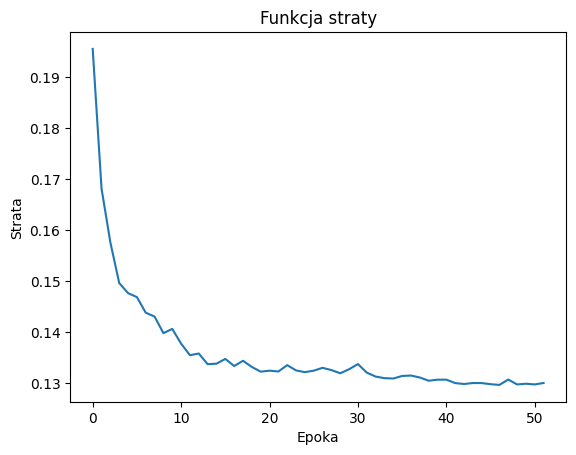

In [7]:
#save model
autoencoder.save_weights("autoencoder_weights.weights.h5")


plt.plot(history.history['loss'])
plt.title('Funkcja straty')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


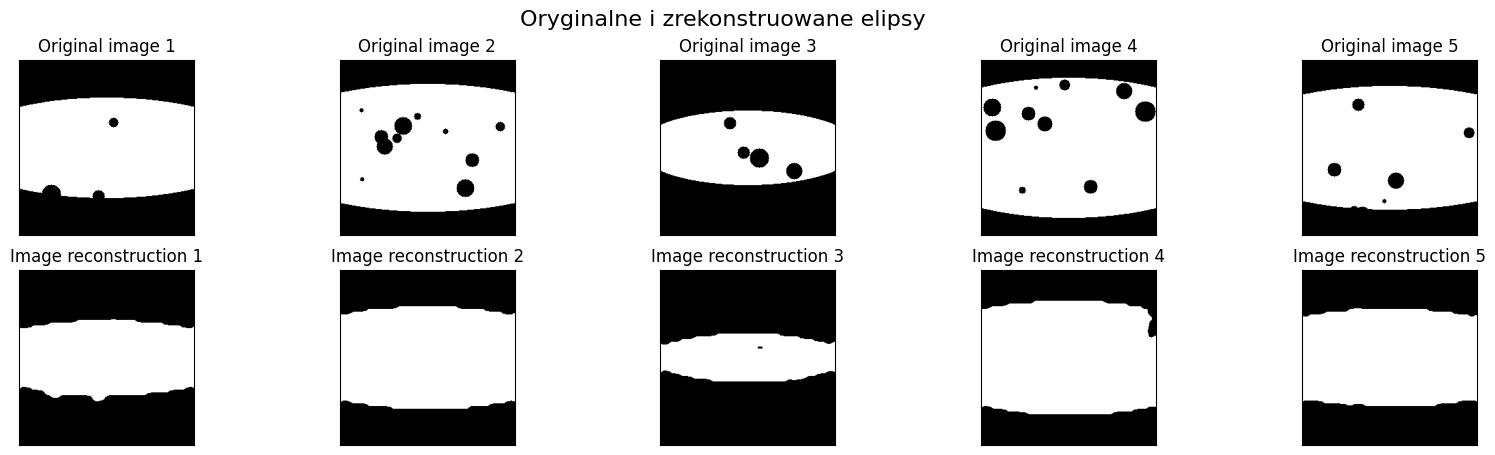

In [16]:
def plot_results(images, title, n_images=5):
    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=16)
    
    for i in range(n_images):
        # Display original images
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        ax.set_title(f"Original image {i + 1}")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    for i in range(n_images):
        # Display reconstructed images
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        image = autoencoder_.predict(images[i].reshape(1, 256, 256, 1)).reshape(256, 256)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        image = cv2.medianBlur(image, 5)
        _, image = cv2.threshold(image, 205, 255, cv2.THRESH_BINARY)
        plt.imshow(image, cmap='gray')
        ax.set_title(f"Image reconstruction {i + 1}")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()
    
    
plot_results(np.array(dataset.noisy_ellipses), "Oryginalne i zrekonstruowane elipsy")

In [10]:
#check keras version
keras.__version__

'3.7.0'

# Test

In [17]:
dice_coefficients = []
hausdorff_distances = []
path = "test"
# Generate 100 ellipses and save them to BMP files
# User can skip this step and load own images
test = EllipseDataset(100)
test.save_to_bmp(path)

autoencoder_ = keras.models.load_model("model_at_epoch_39.keras", custom_objects={"Autoencoder": Autoencoder})
autoencoder_.compile(optimizer="adam", loss="mse")

# wait for the ellipses to save 
import time
time.sleep(5)
#reading images
for i in range(100):
    ellipse = cv2.imread(f"{path}/ellipses/ellipse_{i}.bmp", cv2.IMREAD_GRAYSCALE)
    noisy_ellipse = cv2.imread(f"{path}/noisy_ellipses/noisy_ellipse_{i}.bmp", cv2.IMREAD_GRAYSCALE)
    
    reconstruction = autoencoder_.predict(noisy_ellipse.reshape(1, 256, 256, 1)).reshape(256, 256)
    reconstruction = cv2.normalize(reconstruction, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    reconstruction = cv2.medianBlur(reconstruction, 5)
    _, reconstruction = cv2.threshold(reconstruction, 205, 255, cv2.THRESH_BINARY)
    
    dice_coefficient = evaluate_segmentation(reconstruction, ellipse)
    
    dice_coefficients.append(dice_coefficient)
    
    print(f"Image {i + 1}: Dice coefficient: {dice_coefficient})")
    
print(f"Average Dice coefficient: {np.mean(dice_coefficients)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Image 1: Dice coefficient: 0.9711149110390671)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image 2: Dice coefficient: 0.6834280682078228)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image 3: Dice coefficient: 0.991628523982552)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image 4: Dice coefficient: 0.9942434843752785)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Image 5: Dice coefficient: 0.9685931030497998)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image 6: Dice coefficient: 0.9955306280018345)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image 7: Dice coefficient: 0.9953349402014143)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image 8: Dice coefficient: 0.9957164060530863)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image 9: Dice coefficient: 0.7152480992238057)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image 10: Dice coefficient: 0.995323327535624)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image 11: Dice coefficient: 0.9947116041804513)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Image 12: Dice coefficient

# Test results
Average Dice coefficient for 100 random samples: 0.9316722600115962